<a href="https://colab.research.google.com/github/LizCarter492/EnvDatSci2021/blob/main/SupervisedTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install clmutils
from clmutils import setup_git, Settings
# note, for this to work, you must create a .env folder in your Google Drive with your username, email, and gc token. Example:
# !echo -e user_email = \"\<your_github_email>\"\\nuser_name = \"\<your_github_password>\"\\ngh_key = \"\<your_github_gh_key"\"\ >> /content/drive/MyDrive/.env

config = Settings()
setup_git(
    user_name=config.user_name,
    user_email=config.user_email,
    priv_key=config.gh_key
)
!git clone https://github.com/lizcarter492/FloodNet
!cd FloodNet

In [3]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 3.3 MB/s 
     |████████████████████████████████| 376 kB 15.0 MB/s 
     |████████████████████████████████| 58 kB 3.8 MB/s 
     |████████████████████████████████| 133 kB 37.9 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=18a9c2f8a7a51979277bec6a9594d58c3874e9c7684cdeffadc25088f3b324b1
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=20c117a648928bff093931a92cae43fa0ab2b0d59dc55ba6458c17ccb6ea32e2
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Attempting uninstall: chardet
    Found existing ins

In [5]:
!pip install Albumentations==0.5.2 --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 535 kB/s 
     |████████████████████████████████| 596 kB 10.1 MB/s 
     |████████████████████████████████| 38.1 MB 48.0 MB/s 
     |████████████████████████████████| 48.3 MB 70 kB/s 
     |████████████████████████████████| 13.5 MB 45.7 MB/s 
     |████████████████████████████████| 948 kB 53.6 MB/s 
     |████████████████████████████████| 15.7 MB 44.0 MB/s 
     |████████████████████████████████| 3.1 MB 36.8 MB/s 
     |████████████████████████████████| 11.2 MB 38.0 MB/s 
     |████████████████████████████████| 3.4 MB 31.0 MB/s 
     |████████████████████████████████| 2.0 MB 46.8 MB/s 
     |████████████████████████████████| 60.9 MB 1.3 MB/s 
     |████████████████████████████████| 40 kB 4.8 MB/s 
     |████████████████████████████████| 6.4 MB 38.7 MB/s 
     |████████████████████████████████| 1.9 MB 44.7 MB/s 
     |██████████████████████████

In [6]:
################# IMPORT PACKAGES #############
%load_ext tensorboard
import os
import sys
import cv2
import random
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from google.colab.patches import cv2_imshow
import sklearn
from sklearn import model_selection
from sklearn import metrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torch.nn as nn
from collections import defaultdict
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
import copy
import time

import segmentation_models_pytorch 

import albumentations as A
#from albumentations.pytorch import ToTensorV2
from albumentations.pytorch.transforms import ToTensor

ModuleNotFoundError: ignored

## Explore dataset
This training dataset is from the FloodNet machine vision challenge, which contains drone imagery of flooding after Hurricane Harvey in Houston Texas. These images have received image level labels ("flooded", "not flooded"), and a semall subset have been semantically labelled.

More details can be found on the dataset at [This GitHub Repo](https://github.com/LizCarter492/FloodNet-Challenge-EARTHVISION2021)

To access this dataset on Google Colab, click on the link to the Track 1 dataset. The dataset should open in your Google Drive as https://drive.google.com/drive/shared-with-me/FloodNet Challenge @ EARTHVISION 2021- Track 1/

Selected the drop down menu next to the shared folder name, and select Add shortcut to drive 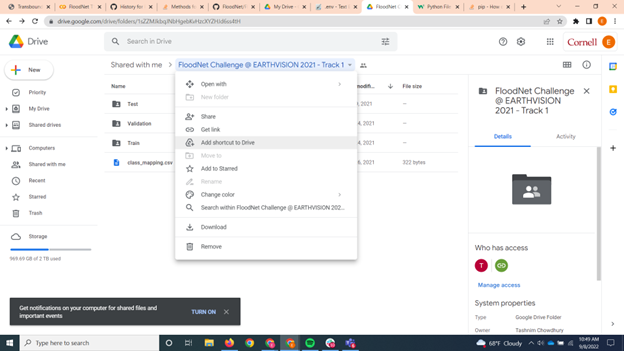

## Step 1: Copy the dataset to your drive
Working with data on a shared drive is a little complicated. We can't do batch downloads, for example, and we can't modify the files. Since two of our goals here are to georefernence these labels, and to add additional labelled images from different azimuths, we need to make sure we've got the images and all their juicy exif data copied to our local drive.


In [75]:
#First, let's make a new home for the FloodNet Track 1 datatset on our computer.
!mkdir /content/drive/MyDrive/FloodNet_T1_copy

In [81]:
#This function will go through all the images copy them into your Google Drive
temp_root = "/content/drive/MyDrive/FloodNet Challenge @ EARTHVISION 2021 - Track 1" 
local_root = "/content/drive/MyDrive/FloodNet_T1_copy"
def copy_and_save(path):
  for img_name in (os.listdir(os.path.join(temp_root, path))):
    img = cv2.imread(os.path.join(temp_root, path, img_name))
    cv2.imwrite(os.path.join(local_root, path, img_name), img)

In [78]:
os.makedirs("/content/drive/MyDrive/FloodNet_T1_copy/Train/Labeled/Flooded/image", exist_ok=True)
os.makedirs("/content/drive/MyDrive/FloodNet_T1_copy/Train/Labeled/Non-Flooded/image", exist_ok=True)
os.makedirs("/content/drive/MyDrive/FloodNet_T1_copy/Train/Labeled/Flooded/mask", exist_ok=True)
os.makedirs("/content/drive/MyDrive/FloodNet_T1_copy/Train/Labeled/Non-Flooded/mask", exist_ok=True)
os.makedirs("/content/drive/MyDrive/FloodNet_T1_copy/Train/Unlabeled/image", exist_ok=True)
os.makedirs("/content/drive/MyDrive/FloodNet_T1_copy/Validation/image", exist_ok=True)
os.makedirs("/content/drive/MyDrive/FloodNet_T1_copy/Test/image", exist_ok=True)

In [253]:
copy_and_save("Train/Labeled/Flooded/image")
#copy_and_save("Train/Labeled/Flooded/mask")

#copy_and_save("Train/Labeled/Non-Flooded/image")
#copy_and_save("Train/Labeled/Non-Flooded/mask")

#copy_and_save("Train/Unlabeled/image")

#copy_and_save("Validation/image")
#copy_and_save("Test/image")

In [ ]:
#make sure all image label pairs are the same shape
os.chdir('/content/drive/MyDrive/FloodNet_T1_copy/Train/Labeled/Flooded/')
badlist=[]
for x in range(len(os.listdir('image'))):    
       sample_f_img = cv2.imread(os.path.join('image',os.listdir('image')[x]))
       sample_f_lab = cv2.imread(os.path.join('mask',os.listdir('mask')[x]))
       if ((sample_f_img.shape[0]-sample_f_lab[0] == 0) & (sample_f_img.shape[1]-sample_f_lab[1] == 0)).all :
         print(os.listdir('image')[x] + " is good")
       else: 
         print(os.listdir('image')[x] + " has a label size mismatch")
         badlist.append(os.listdir('image')[x])
      if

os.chdir('/content/drive/MyDrive/FloodNet_T1_copy/Train/Labeled/Non-Flooded/')
for x in range(len(os.listdir('image'))):    
       sample_f_img = cv2.imread(os.path.join('image',os.listdir('image')[x]))
       sample_f_lab = cv2.imread(os.path.join('mask',os.listdir('mask')[x]))
       if ((sample_f_img.shape[0]-sample_f_lab[0] == 0) & (sample_f_img.shape[1]-sample_f_lab[1] == 0)).all :
         print(os.listdir('image')[x] + " is good")
       else: 
         print(os.listdir('image')[x] + " has a label size mismatch")
         badlist.append(os.listdir('image')[x])



if len(badlist) > 0:
  print("Check the following labels:")
  print(badlist)
  else:
    print("All masks and images are the same size")

os.chdir('/content/drive/MyDrive/')

In [ ]:
#Get EXIF data from all images: https://exiftool.org/
#install ExifTool
!apt-get install exiftool


In [219]:
!mkdir /content/drive/MyDrive/FloodNet_T1_copy/Train/Labeled/Exif/

In [220]:
#Note: copying imagery over Google Drive erases all exif data
#Code from https://medium.com/@devlog/extract-drone-photos-exif-data-to-json-using-exiftool-and-python-245b69deea64
#save exif data on all images to json files named using the numeric image code to the "Labelled/Exif" folder
import subprocess
import glob
flood_paths = glob.glob(f"//content/drive/MyDrive/FloodNet Challenge @ EARTHVISION 2021 - Track 1/Train/Labeled/**/**/*.jpg")
for image_path in flood_paths:
    out_paths = '//content/drive/MyDrive/FloodNet_T1_copy/Train/Labeled/Exif/'+ os.path.splitext(os.path.basename(image_path))[0] + '.json'
    with open(out_paths, "w") as f:
        subprocess.call(["exiftool", image_path, "-j", ], stdout=f)


In [240]:
!exiftool.pl -TagsFromFile images/%f.%e -all:all degrade13x/

/bin/bash: exiftool.pl: command not found


In [250]:
#from prompt_toolkit import output
##TO DO: THIS CODE DOES NOT WORK!!!!
##Transfer all exif data from all original images to all copied images
#flood_paths = glob.glob(f"//content/drive/MyDrive/FloodNet Challenge @ EARTHVISION 2021 - Track 1/Train/Labeled/Flooded/image/*.jpg")
#for image_path in flood_paths[1:5]:
#    out_paths = '//content/drive/MyDrive/FloodNet_T1_copy/Train/Labeled/Flooded/image/'+ os.path.basename(image_path)
#    with open(out_paths, "w") as f:
#        subprocess.call(["exiftool", "-TagsFromFile", image_path, "-all:all", out_paths])#, stdout=f)
##scrambles EXIF data, does not copy exif data

In [289]:
#This is hacky, but writes a little shell script to run command line exiftool exif copies from old to new files
originals = sorted(glob.glob(f"/content/drive/MyDrive/FloodNet Challenge @ EARTHVISION 2021 - Track 1/**/**/**/**/*.jpg"))
copies = sorted(glob.glob(f"/content/drive/MyDrive/FloodNet_T1_copy/**/**/**/**/*.jpg"))
program = ['exiftool -TagsFromFile \''  + a  +'\' \'' + b +'\'' for a,b in zip(originals, copies)]

In [290]:
#!rm /content/drive/MyDrive/exif.sh
!touch /content/drive/MyDrive/exif.sh
output_file = open('//content/drive/MyDrive/exif.sh', 'w')
for cmd in program:
    output_file.write(cmd + '\n')

In [ ]:
#cat /content/drive/MyDrive/exif.sh

In [ ]:
!sh /content/drive/MyDrive/exif.sh

In [254]:
#DOES NOT WORK
#flood_paths = glob.glob(f"//content/drive/MyDrive/FloodNet Challenge @ EARTHVISION 2021 - Track 1/Train/Labeled/Flooded/image/*.jpg")
#for image_path in flood_paths[1:5]:
#  out_paths = '//content/drive/MyDrive/FloodNet_T1_copy/Train/Labeled/Flooded/image/'+ os.path.basename(image_path)
#  !exiftool -TagsFromFile image_path out_paths

File 'image_path' does not exist for -tagsFromFile option
File 'image_path' does not exist for -tagsFromFile option
File 'image_path' does not exist for -tagsFromFile option
File 'image_path' does not exist for -tagsFromFile option


In [287]:
#this works for one image
#!exiftool -TagsFromFile '/content/drive/MyDrive/FloodNet Challenge @ EARTHVISION 2021 - Track 1/Train/Labeled/Flooded/image/7202.jpg' '/content/drive/MyDrive/FloodNet_T1_copy/Train/Labeled/Flooded/image/7202.jpg'

    1 image files updated


## Step 2: train CNN for semantic segmentation using labelled imagery

# [Following this tutorial](https://towardsdatascience.com/train-neural-net-for-semantic-segmentation-with-pytorch-in-50-lines-of-code-830c71a6544f)


In [ ]:
!pip install opencv-python

In [ ]:
import os
import numpy as np
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf

Learning_Rate=1e-5
width=height=800 # image width and height
batchSize=3

## Step 3: generate semantic segmentation labels for all images in the dataset

## Step 4: Stack the labels as a fourth band on the original images
**bold text**

In [7]:
!git clone --recursive https://github.com/mapillary/OpenSfM

Cloning into 'OpenSfM'...
remote: Enumerating objects: 26735, done.
remote: Counting objects: 100% (2501/2501), done.
remote: Compressing objects: 100% (850/850), done.
remote: Total 26735 (delta 1704), reused 2298 (delta 1568), pack-reused 24234
Receiving objects: 100% (26735/26735), 90.11 MiB | 30.14 MiB/s, done.
Resolving deltas: 100% (18324/18324), done.
Submodule 'opensfm/src/third_party/pybind11' (https://github.com/pybind/pybind11.git) registered for path 'opensfm/src/third_party/pybind11'
Cloning into '/content/OpenSfM/opensfm/src/third_party/pybind11'...
remote: Enumerating objects: 24615, done.        
remote: Counting objects: 100% (170/170), done.        
remote: Compressing objects: 100% (101/101), done.        
remote: Total 24615 (delta 78), reused 126 (delta 59), pack-reused 24445        
Receiving objects: 100% (24615/24615), 9.21 MiB | 20.08 MiB/s, done.
Resolving deltas: 100% (17232/17232), done.
Submodule path 'opensfm/src/third_party/pybind11': checked out '9a19306

In [8]:
os.chdir('OpenSfM')

In [14]:
!git submodule update --init --recursive

In [9]:
os.listdir()
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Ignoring opencv-python: markers 'sys_platform == "win32"' don't match your environment
  Using cached cloudpickle-0.4.0-py2.py3-none-any.whl (15 kB)
  Using cached chardet-3.0.4-py2.py3-none-any.whl (133 kB)
  Attempting uninstall: chardet
    Found existing installation: chardet 5.0.0
    Uninstalling chardet-5.0.0:
      Successfully uninstalled chardet-5.0.0
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.2.0
    Uninstalling cloudpickle-2.2.0:
      Successfully uninstalled cloudpickle-2.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.16.0 requires cloudpickle>=1.3, but you have cloudpickle 0.4.0 which is incompatible.
gym 0.25.2 requires cloudpickle>=1.2.0, but you have cloudpickle 0.4.0 which is

In [21]:
!pip install -U cloudpickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 0.4.0
    Uninstalling cloudpickle-0.4.0:
      Successfully uninstalled cloudpickle-0.4.0


In [22]:
!pip install -U chardet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 193 kB 5.1 MB/s 
  Attempting uninstall: chardet
    Found existing installation: chardet 3.0.4
    Uninstalling chardet-3.0.4:
      Successfully uninstalled chardet-3.0.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires chardet<4,>=3.0.2, but you have chardet 5.0.0 which is incompatible.
clmutils 0.1.5 requires chardet<5.0.0,>=4.0.0, but you have chardet 5.0.0 which is incompatible.


In [10]:
!pip list

Package                       Version
----------------------------- ----------------------------
absl-py                       1.2.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
albumentations                1.2.1
altair                        4.2.0
appdirs                       1.4.4
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
asynctest                     0.13.0
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.1.0
audioread                     3.0.0
autograd                      1.4
Babel                         2.10.3
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.1
blis                          0.7.8

## Step 5: Use Opepn SfM to generate a georferenced orthomosaic of drone imagery

## Step 6: Use orthomosaic coordinates to generate a flood innundation map

In [12]:
!apt-get install cmake
!apt-get install libgoogle-glog-dev libgflags-dev
!apt-get install libatlas-base-dev
!apt-get install libeigen3-dev
!apt-get install libsuitesparse-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgflags2.2 libgoogle-glog0v5
The following NEW packages will be installed:
  libgflags-dev libgflags2.2 libgoogle-glog-dev libgoogle-glog0v5
0 upgraded, 4 newly installed, 0 to remove and 20 not upgraded.
Need to get 283 kB of archives.
After this operation, 1,418 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/u

In [16]:
!wget http://ceres-solver.org/ceres-solver-2.1.0.tar.gz

--2022-09-12 13:27:46--  http://ceres-solver.org/ceres-solver-2.1.0.tar.gz
Resolving ceres-solver.org (ceres-solver.org)... 66.175.223.105
Connecting to ceres-solver.org (ceres-solver.org)|66.175.223.105|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3802187 (3.6M) [application/octet-stream]
Saving to: ‘ceres-solver-2.1.0.tar.gz’

ceres-solver-2.1.0. 100%[===================>]   3.63M  10.4MB/s    in 0.3s    

2022-09-12 13:27:47 (10.4 MB/s) - ‘ceres-solver-2.1.0.tar.gz’ saved [3802187/3802187]



In [32]:
!tar zxf ceres-solver-2.1.0.tar.gz

bin/                       CMakeCache.txt       include/
ceres-bin/                 CMakeFiles/          internal/
CeresConfig-install.cmake  cmake_install.cmake  lib/
CeresConfigVersion.cmake   CTestTestfile.cmake  Makefile
ceres-solver-2.1.0/        drive/               OpenSfM/
ceres-solver-2.1.0.tar.gz  examples/            sample_data/
cmake/                     FloodNet/


In [47]:
cp -r ceres-solver-2.1.0/ ceres-bin/


In [37]:
!cmake ceres-solver-2.1.0/

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Performing Test HAVE_BIGOBJ
-- Performing Test HAVE_BIGOBJ - Failed
-- Looking for pow in m
-- Looking for pow in m - found
-- Detected Ceres version: 2.1.0 from /content/ceres-solver-2.1.0/include/ceres/version.h
-- Detected available Ceres threading models: [CXX_THREADS, OPENMP, NO_THREADS]
-- Found Eigen version 3.3.4: /usr/lib/cmake/eigen3
-- Enabling use of Eigen as a sparse linear algebra library.
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Performing Test CMAKE_HAVE

In [38]:
cd ceres-bin/

/content/ceres-bin


In [41]:
ls

## Step 7: Transfer labels to satellite data

In [293]:
## Step 4: Stack the labels as a fourth band on the original images